In [10]:
import numpy as np
import pandas as pd
import pickle, csv
import os

from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, Dropout, Input, concatenate, Flatten, Reshape,MaxPooling3D, Conv3D, TimeDistributed
from keras import regularizers
from keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow.keras.backend as K
from skimage.transform import resize
from tensorflow.keras import layers, models


from matplotlib import pyplot as plt
from matplotlib import style
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

import tensorflow.keras.backend as K
K.clear_session()

In [11]:
# Load powerprice data and format it
df_powerprice = pd.read_csv("data/PowerPrice.csv")
df_powerprice["Time"] = pd.to_datetime(df_powerprice["Time"], infer_datetime_format=True)
df_powerprice = df_powerprice.drop(columns=["Time"])

In [12]:
# Load spatial data and format it
datasets = []
for filename in os.listdir("data/Spatial"):
    if filename.endswith(".pickle"):
        with open(os.path.join("data/Spatial", filename), "rb") as file:
            data = pickle.load(file)
            if data.shape == (100, 35040):
                datasets.append(data)
            else:
                print(f"Skipping {filename}: unexpected shape {data.shape}")

In [13]:
# Convert the list of arrays to a 3D array
spatial_data = np.stack(datasets, axis=0)

spatial_data = spatial_data.reshape((spatial_data.shape[0], spatial_data.shape[1], spatial_data.shape[2]))

# transpose the second and third dimensions to get shape (13, 35040, 100)
spatial_data = spatial_data.transpose((0, 1, 2))

spatial_data.shape

(13, 100, 35040)

In [14]:
# Load mask and reshape to match desired output shape
mask = pd.read_csv("germany/mask.csv", header=None).values
#mask = mask_df.values.reshape((40, 40, 1))

mask.shape

(30, 30)

In [15]:
spatial_data.shape

(13, 100, 35040)

In [16]:
image_all = np.zeros((35040, 30, 30, 13))
for j in range(spatial_data.shape[2]):
    for i in range(spatial_data.shape[0]):
        image = np.zeros((30, 30))
        for s in range(spatial_data.shape[1]):
            image[mask == s] = spatial_data[i,s,j]
        #print(i)
        image_all[j, :, :, i] = image

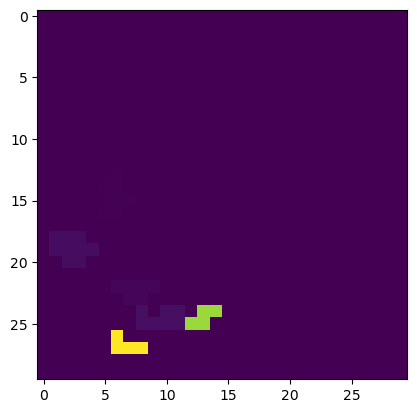

In [17]:
plt.imshow(image_all[35030,:,:,4])
plt.show()

In [18]:
image_all.shape

(35040, 30, 30, 13)

#### getting the result of (35040, 6, 40, 40, 13)

In [19]:
def split_datasets(df, window_size, look_ahead):
    X = []
    y = []
    for i in range(len(df)-window_size-look_ahead):
        row = df[i:i+window_size,:,:,:]
        X.append(row)
        label = df[i+window_size+look_ahead][0][0][0]  # trying to extract first element of label array
        y.append(label)
    return np.array(X), np.array(y)

In [20]:
window_size = 4
look_ahead = 0
X, y = split_datasets(image_all, window_size=window_size, look_ahead=look_ahead)

print(f"X_train shape : {X.shape}")
print(f"y_train shape : {y.shape}")

X_train shape : (35036, 4, 30, 30, 13)
y_train shape : (35036,)


In [22]:
# Split the dataset into training, validation, and testing sets
train_split = int(0.8 * len(X))
val_split = int(0.1 * len(X))

X_train, X_val, X_test = X[:train_split], X[train_split:train_split+val_split], X[train_split+val_split:]
y_train, y_val, y_test = y[:train_split], y[train_split:train_split+val_split], y[train_split+val_split:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (28028, 4, 30, 30, 13)
X_val shape: (3503, 4, 30, 30, 13)
X_test shape: (3505, 4, 30, 30, 13)
y_train shape: (28028,)
y_val shape: (3503,)
y_test shape: (3505,)


In [24]:
X_train.shape[1:]

(4, 30, 30, 13)

In [23]:
model = Sequential()

model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.summary()

2023-05-11 14:21:51.940073: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv3d_1. Consider increasing the input size. Received input shape [None, 1, 14, 14, 32] which would produce output shape with a zero or negative value in a dimension.

In [69]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [70]:
# Fit the model on the training data
history = model.fit(X, y, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10


ValueError: in user code:

    File "C:\Users\113202010\Anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\113202010\Anaconda3\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\113202010\Anaconda3\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\113202010\Anaconda3\lib\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\113202010\Anaconda3\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "C:\Users\113202010\Anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\113202010\Anaconda3\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\113202010\Anaconda3\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\113202010\Anaconda3\lib\site-packages\keras\losses.py", line 1787, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\113202010\Anaconda3\lib\site-packages\keras\backend.py", line 5119, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 13) and (None, 4, 13) are incompatible


#### getting the result of (32, 6, 40, 40, 13)

In [237]:
image = image_slided[np.random.choice(image_slided.shape[0], 32, replace=False)] # just randomly picking the sample from 35035.

image = image.reshape(32, -1, 40, 40, 13)

print(f"image shape: {image.shape}")

image shape: (32, 6, 40, 40, 13)


#### getting the result of (32*6, 40, 40, 13)

In [240]:
image = image.reshape(-1, 40, 40, 13)

image.shape

(192, 40, 40, 13)

In [241]:
df_input = Input(shape=(40, 40, 13))
conv_layer = Conv2D(32, kernel_size=(3,3), activation="relu")(df_input)
conv_layer = MaxPooling2D(pool_size=(2, 2))(conv_layer)
conv_layer = Conv2D(64, kernel_size=(3, 3), activation="relu")(conv_layer)
conv_layer = MaxPooling2D(pool_size=(2, 2))(conv_layer)
flatten_layer = Flatten()(conv_layer)
fcnn_layer = Dense(64, activation="relu")(flatten_layer)
fcnn_layer = Dropout(0.2)(fcnn_layer)
fcnn_layer = Dense(32, activation="relu")(fcnn_layer)
fcnn_layer = Dropout(0.2)(fcnn_layer)
fcnn_output = Dense(10, activation="relu")(fcnn_layer)

fcnn_output.shape

TensorShape([None, 10])

In [242]:
model = Model(inputs=df_input, outputs=fcnn_output)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 40, 40, 13)]      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 38, 38, 32)        3776      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 19, 19, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 17, 17, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 4096)              0   

In [244]:
# Compile the model with optimizer and loss function
model.compile(optimizer='adam', loss='mse')


In [ ]:
CNN

In [ ]:
(32*6, 4, 4, 32)

In [ ]:
Reshape

In [ ]:
(32*6, 4*4*32)

In [ ]:
FNN

In [ ]:
(32*6, 1)

In [ ]:
Reshape

In [ ]:
(32, 6, 1)